In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.model_selection import KFold,TimeSeriesSplit
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import  tqdm
from scipy.stats import pearsonr
pd.set_option('display.max_columns',None)

In [2]:
df_list = pd.read_excel('hs300.xls', sheet_name=None, header=0)
df = pd.concat(df_list.values(), ignore_index=True).dropna().reset_index(drop=True)
df_list = []
df.columns=['id','name','date','open','close','high','low','return','return_percent','pre_close','vwap','volume','value','turnover']
df.replace('--',0,inplace=True)

In [3]:
df_sh300 = pd.read_excel('000300.xls').dropna()
df_sh300.columns=['id','name','date','open','close','high','low','return','return_percent','pre_close']
df_sh300.set_index('date',drop=True,inplace=True)

In [4]:
new_df = df.pivot(index='date', columns='id', values='return_percent').fillna(0)

In [5]:
df_sh300.head()

,id,name,open,close,high,low,return,return_percent,pre_close
date,,,,,,,,,
2018-11-12,000300.SH,沪深300,3160.246,3205.1407,3206.512,3152.439,37.6965,1.1901,3167.4442
2018-11-13,000300.SH,沪深300,3164.922,3237.3823,3254.768,3161.097,32.2416,1.0059,3205.1407
2018-11-14,000300.SH,沪深300,3233.640,3204.9427,3239.244,3200.228,-32.4396,-1.0020,3237.3823
2018-11-15,000300.SH,沪深300,3201.281,3242.3715,3242.383,3198.781,37.4288,1.1678,3204.9427
2018-11-16,000300.SH,沪深300,3242.879,3257.6735,3282.390,3223.721,15.3020,0.4719,3242.3715


# 残差

In [6]:
new_df_resi = new_df.copy()
for name in new_df.columns:
    fit_y = new_df[name]
    fit_x = df_sh300[['return_percent']]
    regression_model = LinearRegression()
    regression_model.fit(fit_x, fit_y)

    # 计算拟合后的残差
    residuals = fit_y - regression_model.predict(fit_x)
    new_df_resi[name] = residuals

In [7]:
columns = new_df.columns
fit_y = new_df[columns[0]]
fit_x = new_df[columns[1:]]

regression_model = LinearRegression()
regression_model.fit(fit_x, fit_y)

# 计算拟合后的残差
residuals = fit_y - regression_model.predict(fit_x)

print("残差:", residuals)

残差: date
2018-11-12   -1.181772
2018-11-13   -0.834687
2018-11-14    0.481055
2018-11-15   -0.501702
2018-11-16   -1.129163
                ...   
2023-11-06    1.207214
2023-11-07   -0.237066
2023-11-08   -0.108711
2023-11-09    0.294826
2023-11-10   -0.895391
Name: 000001.SZ, Length: 1214, dtype: float64


In [8]:
pearsonr(residuals, fit_y)

(0.424964164751048, 2.0438233719525843e-54)

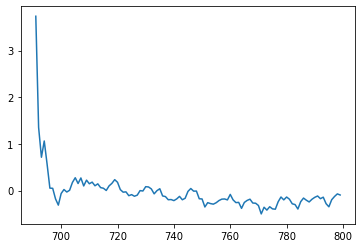

In [9]:
a, b = 691, 800
y = residuals[a:b].ewm(10).mean()

plt.plot(range(a,b), y)

# 因子corr随延迟衰减

In [10]:
df['future_return'] = df['return_percent'].shift(-1)
df.head()

,id,name,date,open,close,high,low,return,return_percent,pre_close,vwap,volume,value,turnover,future_return
0,000001.SZ,平安银行,2018-11-12,10.46,10.56,10.58,10.38,0.01,0.0948,10.55,10.4935,92033388.0,9.657565e+08,0.5360,-0.1894
1,000001.SZ,平安银行,2018-11-13,10.41,10.54,10.65,10.38,-0.02,-0.1894,10.56,10.5057,107249762.0,1.126736e+09,0.6246,-0.9488
2,000001.SZ,平安银行,2018-11-14,10.53,10.44,10.55,10.42,-0.10,-0.9488,10.54,10.4665,77423985.0,8.103577e+08,0.4509,1.7241
3,000001.SZ,平安银行,2018-11-15,10.44,10.62,10.64,10.42,0.18,1.7241,10.44,10.5383,90146198.0,9.499918e+08,0.5250,-0.4708
4,000001.SZ,平安银行,2018-11-16,10.61,10.57,10.72,10.49,-0.05,-0.4708,10.62,10.6000,105959259.0,1.123173e+09,0.6171,2.6490


In [11]:
df['feature'] = ((df['vwap']+df['vwap'])-(df['open']+df['close']))/df['close'].fillna(0)

In [12]:
l_corr_list = []
dif = 1
for i in range(1, 51):
    y = df['return_percent'].shift(-i*dif).fillna(0)
    l_corr_list.append(pearsonr(y, df['feature'])[0])

In [13]:
new_df

id,000001.SZ,000002.SZ,000063.SZ,000069.SZ,000100.SZ,000157.SZ,000166.SZ,000301.SZ,000333.SZ,000338.SZ,000408.SZ,000425.SZ,000538.SZ,000568.SZ,000596.SZ,000617.SZ,000625.SZ,000651.SZ,000661.SZ,000708.SZ,000723.SZ,000725.SZ,000733.SZ,000768.SZ,000776.SZ,000786.SZ,000792.SZ,000800.SZ,000858.SZ,000876.SZ,000877.SZ,000895.SZ,000938.SZ,000963.SZ,000977.SZ,000983.SZ,001289.SZ,001979.SZ,002001.SZ,002007.SZ,002027.SZ,002049.SZ,002050.SZ,002064.SZ,002074.SZ,002120.SZ,002129.SZ,002142.SZ,002179.SZ,002180.SZ,002202.SZ,002230.SZ,002236.SZ,002241.SZ,002252.SZ,002271.SZ,002304.SZ,002311.SZ,002352.SZ,002371.SZ,002410.SZ,002414.SZ,002415.SZ,002459.SZ,002460.SZ,002466.SZ,002475.SZ,002493.SZ,002555.SZ,002594.SZ,002601.SZ,002648.SZ,002709.SZ,002714.SZ,002736.SZ,002756.SZ,002812.SZ,002821.SZ,002841.SZ,002916.SZ,002920.SZ,002938.SZ,003816.SZ,300014.SZ,300015.SZ,300033.SZ,300059.SZ,300122.SZ,300124.SZ,300142.SZ,300207.SZ,300223.SZ,300274.SZ,300316.SZ,300347.SZ,300408.SZ,300413.SZ,300433.SZ,300450.SZ,300454.SZ,300496.SZ,300498.SZ,300601.SZ,300628.SZ,300661.SZ,300750.SZ,300751.SZ,300759.SZ,300760.SZ,300763.SZ,300769.SZ,300782.SZ,300896.SZ,300919.SZ,300957.SZ,300979.SZ,300999.SZ,600000.SH,600009.SH,600010.SH,600011.SH,600015.SH,600016.SH,600018.SH,600019.SH,600025.SH,600028.SH,600029.SH,600030.SH,600031.SH,600036.SH,600039.SH,600048.SH,600050.SH,600061.SH,600085.SH,600089.SH,600104.SH,600111.SH,600115.SH,600132.SH,600150.SH,600176.SH,600183.SH,600188.SH,600196.SH,600219.SH,600233.SH,600276.SH,600309.SH,600332.SH,600346.SH,600362.SH,600383.SH,600406.SH,600426.SH,600436.SH,600438.SH,600460.SH,600519.SH,600547.SH,600570.SH,600584.SH,600585.SH,600588.SH,600600.SH,600606.SH,600660.SH,600674.SH,600690.SH,600732.SH,600741.SH,600745.SH,600754.SH,600760.SH,600763.SH,600795.SH,600803.SH,600809.SH,600837.SH,600845.SH,600875.SH,600884.SH,600886.SH,600887.SH,600893.SH,600900.SH,600905.SH,600918.SH,600919.SH,600926.SH,600941.SH,600958.SH,600989.SH,600999.SH,601006.SH,601009.SH,601012.SH,601021.SH,601066.SH,601088.SH,601100.SH,601111.SH,601117.SH,601138.SH,601155.SH,601166.SH,601169.SH,601186.SH,601211.SH,601216.SH,601225.SH,601229.SH,601236.SH,601238.SH,601288.SH,601318.SH,601319.SH,601328.SH,601336.SH,601360.SH,601377.SH,601390.SH,601398.SH,601600.SH,601601.SH,601607.SH,601615.SH,601618.SH,601628.SH,601633.SH,601658.SH,601668.SH,601669.SH,601688.SH,601689.SH,601698.SH,601699.SH,601728.SH,601766.SH,601788.SH,601799.SH,601800.SH,601808.SH,601816.SH,601818.SH,601838.SH,601857.SH,601865.SH,601868.SH,601872.SH,601877.SH,601878.SH,601881.SH,601888.SH,601898.SH,601899.SH,601901.SH,601919.SH,601939.SH,601985.SH,601988.SH,601989.SH,601995.SH,601998.SH,603019.SH,603185.SH,603195.SH,603259.SH,603260.SH,603288.SH,603290.SH,603369.SH,603392.SH,603486.SH,603501.SH,603659.SH,603799.SH,603806.SH,603833.SH,603899.SH,603986.SH,603993.SH,605117.SH,605499.SH,688005.SH,688008.SH,688012.SH,688036.SH,688065.SH,688111.SH,688126.SH,688187.SH,688223.SH,688303.SH,688363.SH,688396.SH,688561.SH,688599.SH,688981.SH
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-11-12,0.0948,1.4013,1.6608,2.5907,2.0243,4.7059,1.1364,1.5929,0.9303,1.0796,0.8197,2.0896,0.0000,-0.4876,-0.4013,0.5425,3.1646,1.4752,1.8555,2.7352,1.2987,3.9427,2.4765,1.7532,2.3809,1.8362,1.9380,2.6746,0.0800,1.7488,2.5956,0.0000,3.2676,-1.0652,3.8482,1.7572,0.0000,1.4664,3.6290,3.1944,2.0979,3.3162,2.6381,1.7677,0.7026,-3.1145,3.0945,-0.4079,0.8788,1.7871,10.0101,2.4431,7.2337,2.8649,0.0000,5.1357,-1.6537,-0.2359,0.5635,3.6284,4.0471,2.6349,5.4269,-6.6256,1.3682,0.5030,3.5644,0.3788,5.6761,3.2200,0.2183,5.7282,3.3898,0.3534,0.8782,1.8590,5.0119,5.1736,5.8871,5.0532,2.4915,2.4442,0.0000,3.5714,1.1853,3.9823,4.2139,1.3146,3.4968,4.2874,3.5336,0.0000,10.0551,5.7748,4.4444,1.5152

# 个股平均

In [14]:
def feature_cal(df):
    return ((df['vwap']+df['vwap'])-(df['high']+df['low']))/df['close'].fillna(0)

In [15]:
s = 0
bestname = []
for name in tqdm(new_df.columns[:]):
    small_df = df[df['id']==name].copy()
    feature = feature_cal(small_df)
    corr = pearsonr(feature, small_df['return_percent'].shift(-1).fillna(0))[1]
    if (corr) < 0.001:
        bestname.append(name)
    
len(bestname)

  0%|          | 0/300 [00:00<?, ?it/s]

100%|██████████| 300/300 [00:07<00:00, 42.49it/s]


15

100%|██████████| 15/15 [00:00<00:00, 28.86it/s]


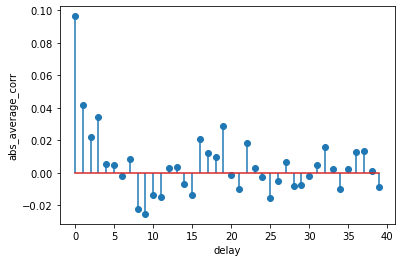

In [16]:
n = 40
l_corr_list = [0 for i in range(n)]
name_list = ['601988.SH']
name_list = new_df.columns[:]
name_list = bestname

for name in tqdm(name_list):
    small_df = df[df['id']==name].copy()
    feature = feature_cal(small_df)
    for i in range(1, n+1):
        l_corr_list[i-1] += (pearsonr(feature, small_df['return_percent'].shift(-i).fillna(0))[0])/len(name_list)

plt.stem(range(n), np.array(l_corr_list))
plt.xlabel('delay')
plt.ylabel('abs_average_corr')
plt.show()

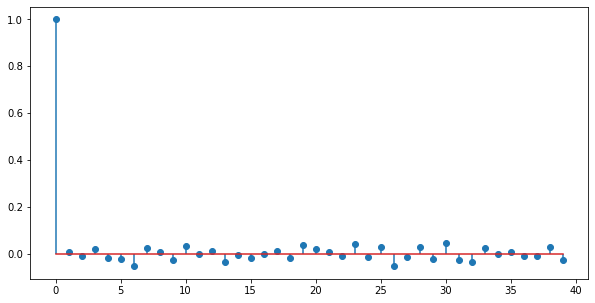

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

series = pd.Series(df_sh300['return_percent'])

autocorrelation = series.autocorr()

# 计算不同滞后阶数的自相关系数
lags = range(40)
autocorrelations = [series.autocorr(lag) for lag in lags]

plt.figure(figsize=(10, 5))
plt.stem(lags, autocorrelations)
plt.show()

# 和vol之间的联系

In [18]:
new_df = df.pivot(index='date', columns='id', values='return_percent').fillna(0)

In [41]:
def feature_cal(df):
    #return ((df['vwap']+df['vwap'])-(df['high']+df['low']))/df['close'].fillna(0)
    # return (df['volume']).diff().fillna(0)
    # return df['return_percent'].rolling(10).std().fillna(0)
    return df['return_percent']

In [42]:
length = 10

df['vol_30'] = df.groupby('id')['return_percent'].rolling(length).std().shift(-length).values
df['vol'] = df['vol_30']**2

#df['vol'] = df['return_percent']**2

In [43]:
s = 0
bestname = []
for name in tqdm(new_df.columns[:]):
    small_df = df[df['id']==name].copy().dropna()
    feature = np.abs(feature_cal(small_df))
    corr = pearsonr(feature[:-1], small_df['vol'].shift(-1)[:-1])
    if (corr[1]) < 0.05:
        bestname.append(name)
    
len(bestname)

  0%|          | 0/300 [00:00<?, ?it/s]

100%|██████████| 300/300 [00:05<00:00, 59.70it/s]


277

  0%|          | 0/277 [00:00<?, ?it/s]

100%|██████████| 277/277 [00:17<00:00, 15.61it/s]


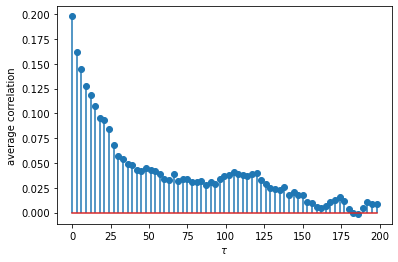

In [44]:
n = 200
l_corr_list = [0 for i in range(n)]
l_corr_list_ = [0 for i in range(n)]
#bestname = new_df.columns
test_names = bestname[:]

for name in tqdm(test_names):
    small_df = df[df['id']==name].copy().dropna()
    feature = np.abs(feature_cal(small_df))
    for i in range(1, n+1):
        try:
            pear = pearsonr(feature[:-i:3], small_df['vol'].shift(-i)[:-i:3])
        except ValueError:
            pear = (0, 1)
        l_corr_list[i-1] += (pear[0]*(pear[1]<0.05))/len(test_names)
        l_corr_list_[i-1] += (pear[0])/len(test_names)

step = 3
plt.stem(range(0,n,step), np.array(l_corr_list[::step]))
#plt.scatter(range(n), np.array(l_corr_list_),c='r')
plt.xlabel(r'$ \tau$')
plt.ylabel('average correlation')
#plt.title(r'relation between corr and $\tau$')
plt.show()

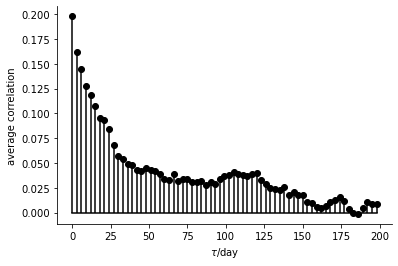

In [45]:
step = 3
plt.stem(range(0,n,step), np.array(l_corr_list[::step]), linefmt='black', markerfmt='ko', basefmt='k-')
ax = plt.gca()

# 隐藏右边和上边的边框
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
#plt.scatter(range(n), np.array(l_corr_list_),c='r')
plt.xlabel(r'$ \tau$/day')
plt.ylabel('average correlation')
#plt.title(r'relation between corr and $\tau$')
plt.show()

100%|██████████| 268/268 [00:09<00:00, 29.59it/s]


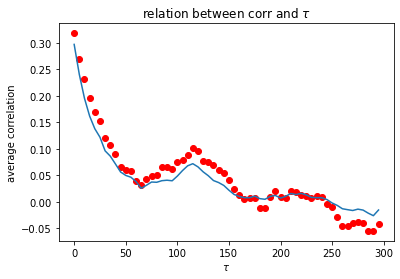

In [24]:
n = 300
step = 5
l_corr_list = [0 for i in range(0,n,step)]
l_corr_list_ = [0 for i in range(0,n,step)]
#bestname = new_df.columns
test_names = bestname[:]

for name in tqdm(test_names):
    small_df = df[df['id']==name].copy().dropna()
    feature = np.abs(feature_cal(small_df))
    for i in range(1, n+1, step):
        pear = pearsonr(feature[:-i:3], small_df['vol'].shift(-i)[:-i:3])
        l_corr_list[(i-1)//step] += (pear[0]*(pear[1]<0.001))/len(test_names)
        l_corr_list_[(i-1)//step] += (pear[0])/len(test_names)

plt.plot(range(0,n,step), np.array(l_corr_list))
plt.scatter(range(0,n,step), np.array(l_corr_list_),c='r')
plt.xlabel(r'$ \tau$')
plt.ylabel('average correlation')
plt.title(r'relation between corr and $\tau$')
plt.show()

# 股票corr

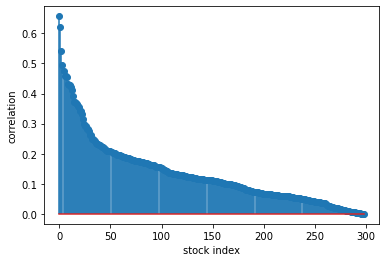

In [25]:
stocks = new_df_resi.columns
corr_list = [abs(pearsonr(new_df_resi[stocks[0]],new_df_resi[stocks[i]])[0]) for i in range(1,300)]

(corr_list).sort(reverse= True)
plt.stem(range(299), corr_list, linefmt='black', markerfmt='ko', basefmt='k-')
ax = plt.gca()

# 隐藏右边和上边的边框
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.xlabel('stock index')
plt.ylabel('correlation')
plt.show()

In [46]:
new_df_vol = df.pivot(index='date', columns='id', values='vol').fillna(0)
new_df_resi = new_df.copy()
aver =  np.array(new_df_vol.T.mean()).reshape(-1,1)
for name in new_df_vol.columns:
    fit_y = new_df_vol[name]
    fit_x = aver
    regression_model = LinearRegression()
    regression_model.fit(fit_x, fit_y)

    # 计算拟合后的残差
    residuals = fit_y# - regression_model.predict(fit_x)
    new_df_resi[name] = residuals

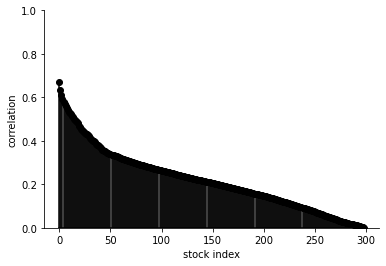

0.2192817148829374


In [47]:
stocks = new_df_resi.columns
corr_list_ = [0 for i in stocks]
for i in range(len(stocks)):
    corr_list = [abs(pearsonr(new_df_resi[stocks[i]],new_df_resi[stocks[j]])[0]) for j in range(len(stocks))]
    (corr_list).sort(reverse= True)
    for j in range(len(stocks)):
        corr_list_[j] += corr_list[j]/len(stocks)
plt.stem(range(len(stocks)-1), corr_list_[1:], linefmt='black', markerfmt='ko', basefmt='k-')
ax = plt.gca()

# 隐藏右边和上边的边框
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.xlabel('stock index')
plt.ylabel('correlation')
plt.ylim(0,1)
plt.show()
print(sum(corr_list_[1:])/(len(corr_list_)-1))

# 沪深300

In [55]:
df_sh300.head()

,id,name,open,close,high,low,return,return_percent,pre_close,value,vol
date,,,,,,,,,,,
2018-11-12,000300.SH,沪深300,3160.246,3205.1407,3206.512,3152.439,37.6965,1.1901,3167.4442,9.083462e+10,1.288454
2018-11-13,000300.SH,沪深300,3164.922,3237.3823,3254.768,3161.097,32.2416,1.0059,3205.1407,1.101663e+11,1.219201
2018-11-14,000300.SH,沪深300,3233.640,3204.9427,3239.244,3200.228,-32.4396,-1.0020,3237.3823,9.516467e+10,1.292190
2018-11-15,000300.SH,沪深300,3201.281,3242.3715,3242.383,3198.781,37.4288,1.1678,3204.9427,9.122826e+10,1.263919
2018-11-16,000300.SH,沪深300,3242.879,3257.6735,3282.390,3223.721,15.3020,0.4719,3242.3715,1.141935e+11,1.323851


Text(0, 0.5, 'volatility')

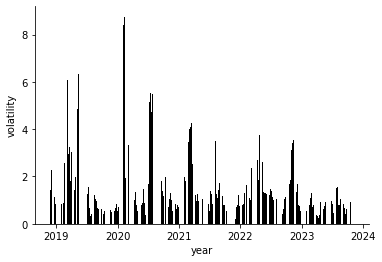

In [76]:
plt.bar(pd.to_datetime(df_sh300.index)[::], (df_sh300['return_percent']**2).rolling(10).mean()[::], color='black')
ax = plt.gca()

# 隐藏右边和上边的边框
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.xlabel('year')
plt.ylabel(r'volatility')

In [28]:
def feature_cal(df):
    #return ((df['close']*2)-(df['high']+df['low']))/df['close'].fillna(0)
    return df['value']
    #return np.abs(df['return_percent'])

In [29]:
df_sh300['value'] = df.groupby('date')['value'].sum().values

In [30]:
length = 10

df_sh300['vol'] = df_sh300['return_percent'].rolling(length).std().shift(-length)

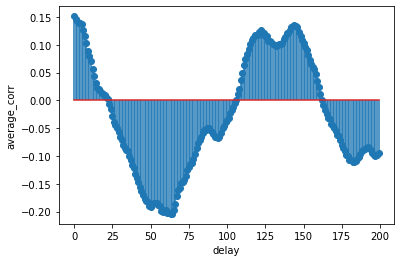

In [31]:
n = 200

small_df = df_sh300.dropna()
feature = np.abs(feature_cal(small_df))
l_corr_list= [(pearsonr(feature[:-i], small_df['vol'].shift(-i)[:-i])[0]) for i in range(1, n+1)]

plt.stem(range(n), np.array(l_corr_list))
plt.xlabel('delay')
plt.ylabel('average_corr')
plt.show()

# 自相关性

  0%|          | 0/277 [00:00<?, ?it/s]

100%|██████████| 277/277 [00:18<00:00, 15.37it/s]


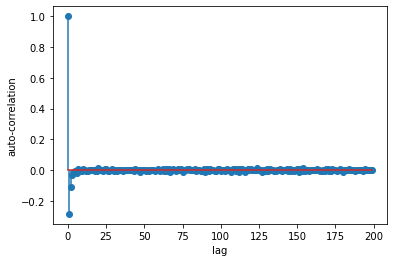

In [53]:
n = 200
l_corr_list = [0 for i in range(n)]
l_corr_list_ = [0 for i in range(n)]
#bestname = new_df.columns
test_names = bestname[:]

for name in tqdm(test_names):
    small_df = df[df['id']==name].copy().dropna()
    series = pd.Series((small_df['volume'].diff()).fillna(0))

    autocorrelation = series.autocorr()

    # 计算不同滞后阶数的自相关系数
    lags = range(n)
    for lag in lags:
        l_corr_list[lag] += series.autocorr(lag)/len(test_names)

plt.stem(range(n), np.array(l_corr_list))
#plt.scatter(range(n), np.array(l_corr_list_),c='r')
plt.xlabel(r'lag')
plt.ylabel('auto-correlation')
#plt.title(r'auto')
plt.show()

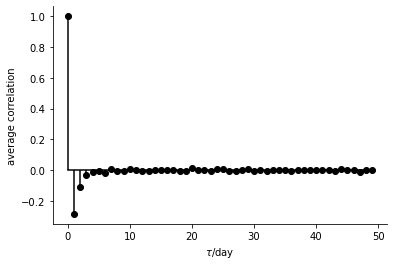

In [54]:
step = 1
plt.stem(range(0,50,step), np.array(l_corr_list[:50:step]), linefmt='black', markerfmt='ko', basefmt='k-')
ax = plt.gca()

# 隐藏右边和上边的边框
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
#plt.scatter(range(n), np.array(l_corr_list_),c='r')
plt.xlabel(r'$ \tau$/day')
plt.ylabel('average correlation')
#plt.title(r'relation between corr and $\tau$')
plt.show()